# Self Driving Car Laboratory ECAM 2019

## Libraries 

- Tensorflow : Machine learning library (For this project a GPU version is used)
- Keras : High-level neural networks API for Deep learnings that uses Tensorflow as a backend
- CV2 : Image Processing library.
- Pandas : Library used for data stucture and data analysis (Handle the dataset csv file)
- imgaug : Library used for image aumgmentation to easy flip, to easily generate images from exsitant ones through image tranformations technics.
- Sklearn : Machine learning library used to efficiently split our dataset to train validattion sets and also to shufle throught learning process.
- Matplotlib : A libray used to dispaly graphics and images from the data we are manipulating.


## Installation 

### MacOS Linux

```bash
python -m pip install -r requierments.txt
```

### Windows 

Shapely which is a library used by imgaug need to be installed manually using the [.whl file](https://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely)

Then install the requiermenrts : 
```bash
python -m pip install -r requierments.txt
```


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


## Dataset 

The dataset is generated using the udacity self driving simulator. It stores every frame while recording through 3 cameras (left, center, right), it also saves un a .csv file all the action taken by the driver (steering, throttle, reverse, speed) 

- Speed : a value between [0,30] expressing mph
- Throttle : a value between [0.0, 1.0], 1 means not throttling at all
- Steering : [-1.0, 1.0] where the extreme values are [left, right] and 0 is straight

In [4]:
datadir = '..\Map2_Hybrid'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_637.jpg   
1  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_707.jpg   
2  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_777.jpg   
3  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_846.jpg   
4  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_45_914.jpg   

                                                                      left  \
0  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_637.jpg   
1  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_707.jpg   
2  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_777.jpg   
3  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_846.jpg   
4  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_45_914.jpg   

                                                                      right  \
0  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_637.jpg   
1  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_707.jpg   
2  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_777.jpg   
3  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_846.jpg   
4  C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_45_914.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.580278  0.0      0.555763  
1  0.0       0.816568  0.0      1.197916  
2  0.0       0.997550  0.0      1.831465  
3  0.0       1.000000  0.0      2.716950  
4  0.0       1.000000  0.0      3.379713

### Data distribution

With this histogram we want to display the distribution of our dataset. We concluded that our dataset is not well balanced and it may lead to a false learning since we have 7000 '0' values our model will likely tend to go straight.

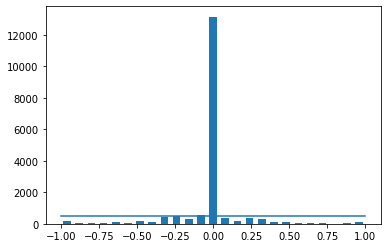

In [5]:
max_bars = 25
treshold = 500
hist, bars = np.histogram(data['steering'], max_bars)
center = (bars[:-1]+ bars[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

### Data Cleaning
Thus we decided to only keep 400 '0' values. This treshold results from testing differents value starting from 3500 and reducing, the feedback was the behaviour of our model in the simulator he tends to ignore some bends and not turning at the right time.

total data: 17526
removed: 12734
remaining: 4792


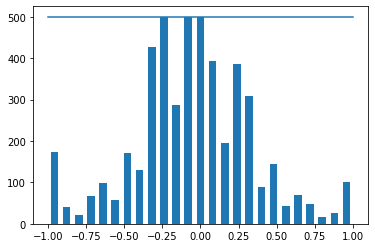

In [6]:
print('total data:', len(data))
remove_list = []
for j in range(max_bars):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bars[j] and data['steering'][i] <= bars[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[treshold:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (max_bars))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

In [7]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()[-34:]))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()[-32:]))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()[-33:]))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      C:\Users\Salim\Desktop\Map2 Hybrid\IMG\center_2019_06_16_14_16_46_610.jpg
left        C:\Users\Salim\Desktop\Map2 Hybrid\IMG\left_2019_06_16_14_16_46_610.jpg  
right       C:\Users\Salim\Desktop\Map2 Hybrid\IMG\right_2019_06_16_14_16_46_610.jpg 
steering    0.05                                                                     
throttle    1                                                                        
reverse     0                                                                        
speed       11.1057                                                                  
Name: 14, dtype: object


### Data slipting (Train-Test)

We devided our dataset to train-test using the train_test_split function provided by sklearn lib.

Definition of arguments : 
    
   - test_size : The size in percentage of the test dataset 0.2 means 20%
   - random_state : 
        

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 11500
Valid Samples: 2876




The two sets look to have to same shape, which is a good thing because __TBD__



Text(0.5, 1.0, 'Test set')

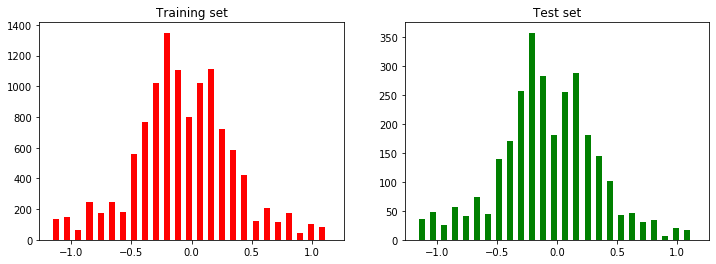

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=max_bars, width=0.05, color='red')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=max_bars, width=0.05, color='green')
axes[1].set_title('Test set')

## Data augmentation
Having a bigger dataset improves the model's precision, because the model receives more examples to train on.
Data augmentation is done by using the original dataset to create new data.
For the processing of images, there are multiple operations that can be applied to the dataset. For example, if a model is trained to detect specifc objet. The images could be rotated so that the learning is done with the original dataset plus the rotated version. The goal is to create a model that detect the object no matter its orientation.



### Zoom


In [10]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed Image')

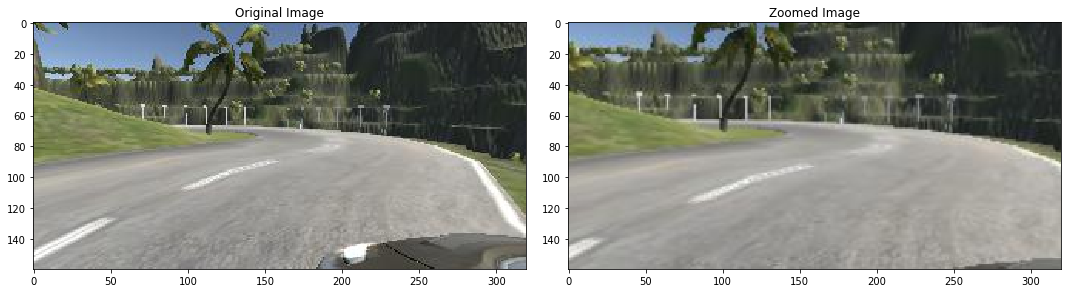

In [11]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

### Translation

In [12]:
def translate(image):
  translate = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = translate.augment_image(image)
  return image

Text(0.5, 1, 'Translated Image')

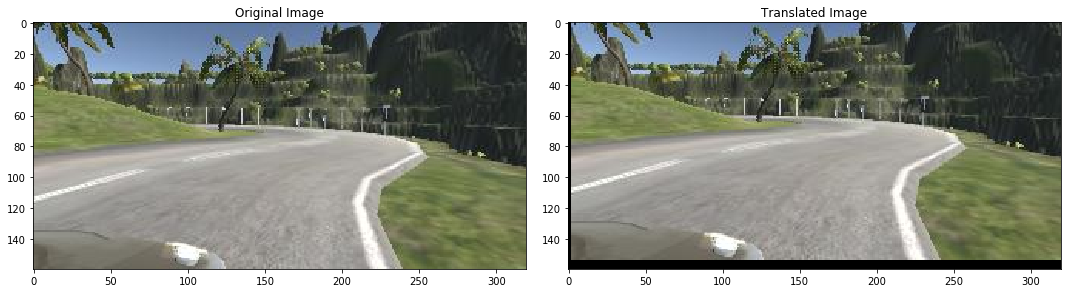

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
translated_image = translate(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(translated_image)
axs[1].set_title('Translated Image')

### Brightness

In [14]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Brightness altered image')

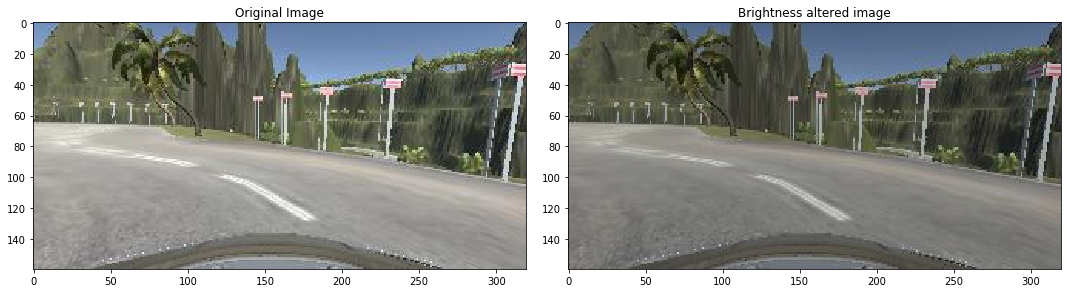

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

### Flip

In [16]:
def img_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1, 'Flipped Image - Steering Angle:0.2')

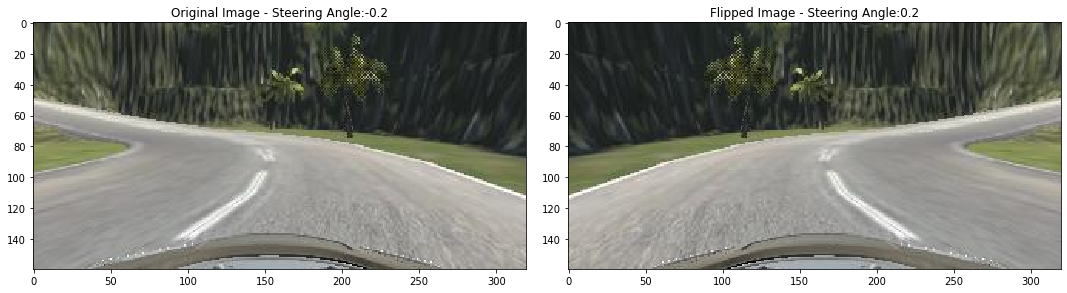

In [17]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

### Randomizing process

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = translate(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_flip(image, steering_angle)
    
    return image, steering_angle

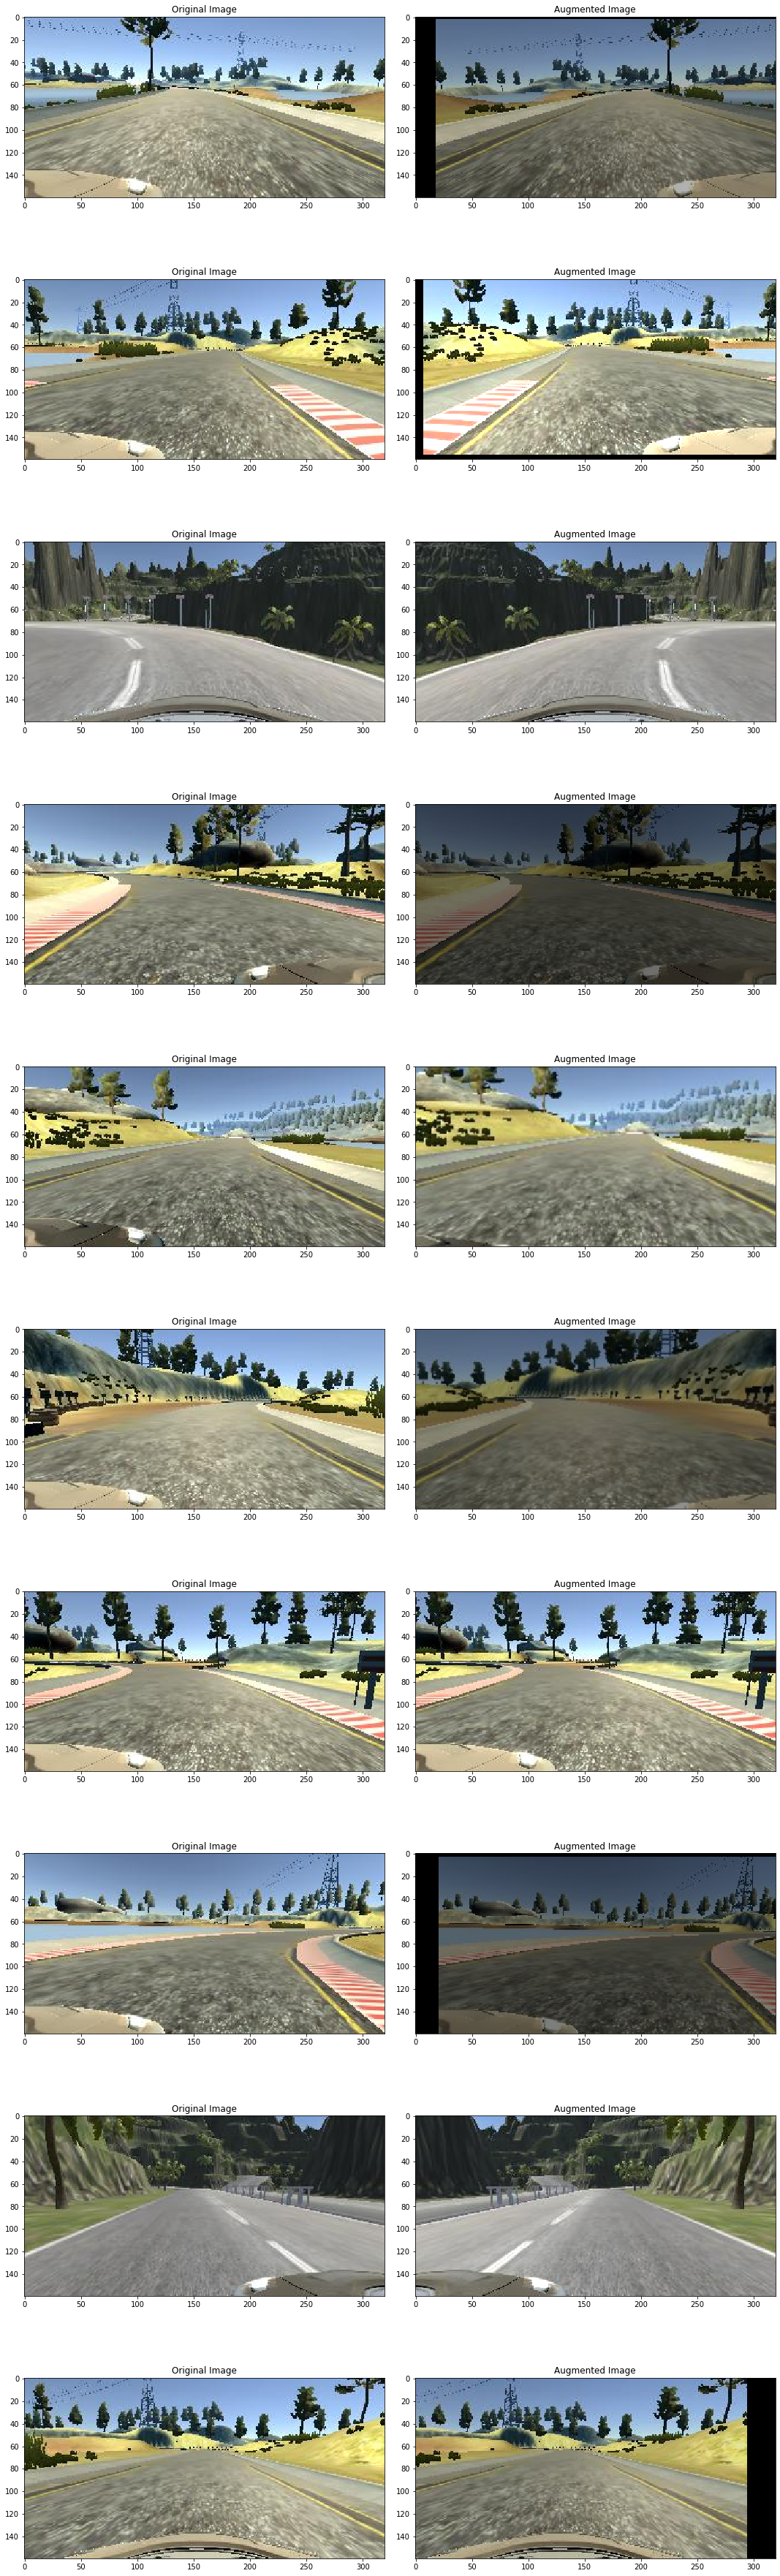

In [19]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

## Image processing

![image processing pipeline](imgpipeline.jpg)

- Crop : Delete unecessry details on the image, only focus on the road.
- RGB 2 YUV : 
- Gaussian Blur : 
- Resize : Nvidia Model need an input data that has a size of 200x60 because the convolutional kernels are adapted to the specific size.
- Normalization : Decrease computational complexity

### YUV vs RGB

In [20]:
def img_preprocess(img, model):
    shapes =	{
      "vgg": (64, 64),
      "nvidia": (200, 66),
      "dummy": (32, 32)
    }
    img = img[60:135,:,:]
    if(model == "nvidia"):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, shapes[model])
    img = img/255
    return img

Text(0.5, 1, 'Preprocessed Image')

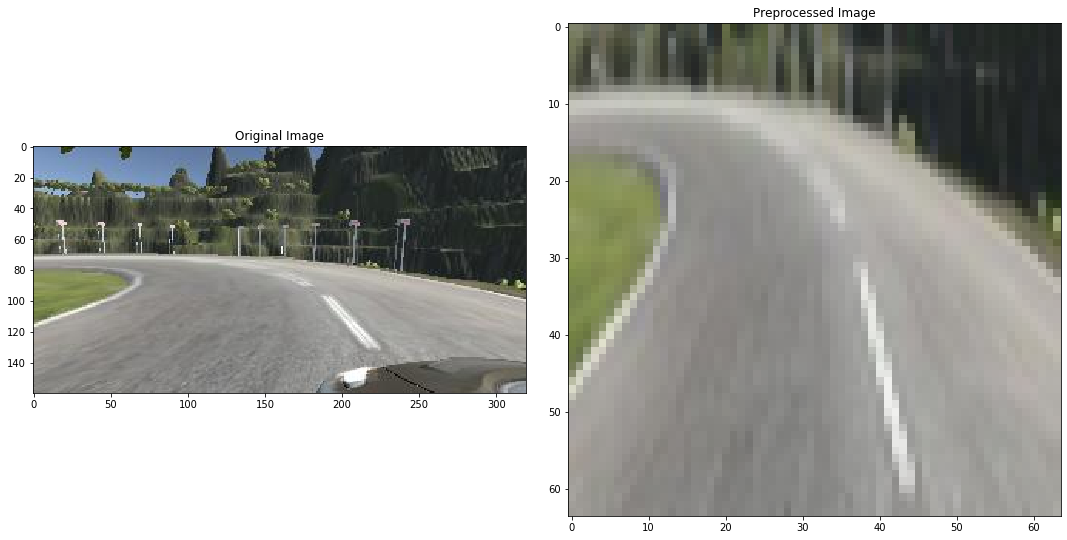

In [21]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image, 'vgg')
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining, model):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im, model)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1, 'Validation Image')

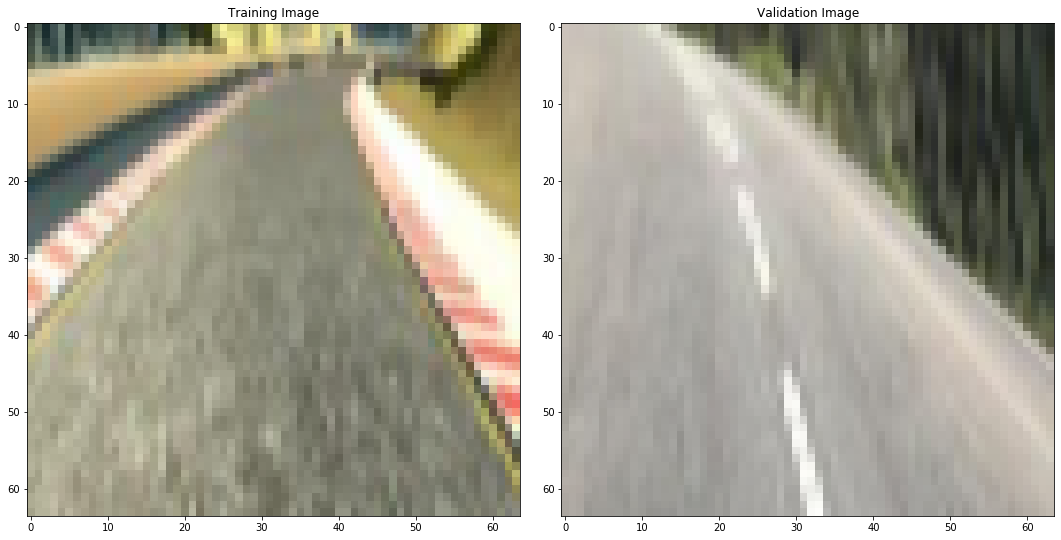

In [23]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1, 'vgg'))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0,'vgg'))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

# Convolutional Neural Network
Type of Neural Networks developed for computation vision application. 

Each CNN learns to map images to specific classes or a specific value by updating its parameters (weights & bias).

A CNN can be composed of tree types of layers:
- A Convolutional layer
- A Pooling layer
- A Fully-connected layer: Only present once

The number of convolutional and pooling layers depends on the problem complexity. If the model has to detect low level features, those layers have to be present multiple time. But by increasing the number of layers, the required computational power is increased.

The previous layers can be combined in different ways to create different architectures. The state-of-the-art CNNs are different combination of the those layers.

## Convolutional Layer
IMAGE

The basic component of this layer is the kernel or filter. It's a matrix of defined dimension that is applied on the input image to extract features. The values of the kernel are randomly selected at the beginnning of the training, then improved during the training. 

The kernel is applied on a specific part of the image, then it's shifted by a certain distance defined by the stride value. This process is repeated until the full image has been coverred. The result of this process is a matrix called the Convolved Feature or Feature Map. There could be more than one feature map, each one extracting different features.

## Pooling Layer
IMAGE

This layer is used to reduce the dimensionality of the feature map to reduce the computational complexity and to converge faster.

We used a pooling layer called Max Pooling. A matrix of a specific size is applied on some part the image, and then the maximum value in that matrix is kept. This process is repeated until the image is covered.  

The advantage of the max pooling process, is that only the dominant values are kept and the noises are removed.



## Flatten
IMAGE

The flatten method is used to transform the result of the pooling layer into a column matrix.


## Dense or Fully-Connected Layer
IMAGE

This layer is a classical Neural Network that learns to find the non-linear realthionship between the input and the output. The input of the this layer is the column matrix generated by the flatten method.



## Nvidia Model


## VGG16 Model



In [24]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), subsample=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  
  model.add(Conv2D(64, (3, 3), activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [25]:
def dummy_model():
    model = Sequential()
    model.add(Conv2D(15, 3, 3, subsample=(2, 2), input_shape=(32,32,3), activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(1))
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [24]:
def vgg16_model(): 
    
    model=Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(64, 64, 3),padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [26]:
model = dummy_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1,'dummy'),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0,'dummy'),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


c:\users\salim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), input_shape=(32, 32, 3..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 15)        420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 15)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 735)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 736       
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 110s 368ms/step - loss: 0.1481 - 

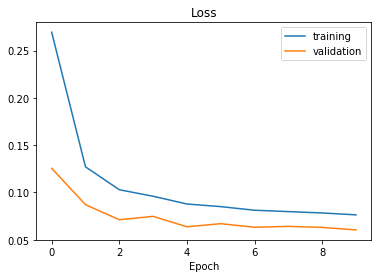

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model_dummy_hybrid_rockissue.h5')